# Union de archivo de velocidades del plan maestro de movilidad

Se agregan las velocidades del plan maestro de movilidad para aumentar los datos

## Necesarios
* Base de datos de velocidades en excel
* Base de datos de velocidades
* Librerias necesarias instaladas

In [1]:
# Tratamiento de datos
# ==============================================================================
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gpd
import math as mt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se carga el archivo de excel que contienelas celdas tener en cuenta de hacer coinsidir el nombre
#de las columnas que mas se puedan para asi hacer un mejor uso de los datos
#archcarro = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/carro.xlsx'
#archmoto = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/Moto.xlsx'
#archTPC = 'C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/TPC.xlsx'

#dfcar = pd.read_excel(archcarro, sheet_name='Hoja1')
#dfmot = pd.read_excel(archmoto, sheet_name='Hoja1')
#dfTPC = pd.read_excel(archTPC, sheet_name='Hoja1')

#print(dfcar.head(2))
#print(dfmot.head(2))
#print(dfTPC.head(2))

In [3]:
#Se llaman los datos de velocidad obtenidos en el GPX
velcar = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Carro.shp")
velmot = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Moto.shp")
velTPC = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/TPC.shp")
velBici = gpd.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Bici2.shp")
gdfBici = velBici
print(velcar.head(2))
print(velmot.head(2))
print(velTPC.head(2))
print(velBici.head(2))

   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.43089 -75.24018 1217.72900  11-09-2020  12:25:01   
1   2  4.43089 -75.24017 1217.56100  11-09-2020  12:25:02   

             timestamp                            file        t0         A0  \
0  2020-09-11 12:25:01  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   
1  2020-09-11 12:25:02  2020-09-11_07-25_Fri CARRO.gpx  12:25:01 1217.72900   

   velocity_m  velocity_k     slope                       geometry  
0     0.00000     0.00000   0.00000  POINT (870947.965 981821.229)  
1     0.20794     0.74860 -80.79070  POINT (870947.887 981821.168)  
   ID  latitud  longitud     altura       fecha    tiempo  \
0   1  4.40523 -75.16315 1029.02100  09-09-2020  17:09:58   
1   2  4.40523 -75.16315 1029.05400  09-09-2020  17:09:59   

             timestamp                           file        t0         A0  \
0  2020-09-09 17:09:58  2020-09-09_12-09_Wed moto.gpx  17:09:58 1029.02100   
1  2020-09-09 17:09:59  2020-09

## Bici

In [4]:
#Para obterner el geometry de estas velocidades en excel se localizan segun las coordenadas
#gdfBici = gpd.GeoDataFrame(
#    dfBici, geometry=gpd.points_from_xy(dfBici.longitud, dfBici.latitud),crs={"init":"EPSG:4326"})

In [5]:
#Se convierte el formato a magna sirgas bogota
gdfBici = gdfBici.to_crs({"init":"EPSG:3116"})

In [6]:
#Se visualizan los datos para entender mejor
gdfBici.head(2)

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,0.00000,0.00000,0.00000,POINT (876337.148 982682.663)
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,5.94567,21.40440,22.70562,POINT (876338.177 982680.433)


<AxesSubplot:>

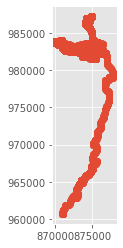

In [7]:
#Se grafican para visualizar que los datos sean coherentes con la malla vial
gdfBici.plot()

In [8]:
#Se crea la columna de angulos
gdfBici['angulo_vel']=0.0

In [9]:
#se toman los atributos para calcular el azimut
for i in range(0, len(gdfBici)-1):
    if  (gdfBici["file"].iloc[i] == gdfBici["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=gdfBici.loc[i,'geometry'].x
        y1=gdfBici.loc[i,'geometry'].y
        x2=gdfBici.loc[i+1,'geometry'].x
        y2=gdfBici.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=gdfBici.iloc[i-1,-1]                
    gdfBici.loc[i,'angulo_vel']=ang
gdfBici.loc[i+1,'angulo_vel']=ang
gdfBici

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,angulo_vel
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,0.00000,0.00000,0.00000,POINT (876337.148 982682.663),155.23093
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,5.94567,21.40440,22.70562,POINT (876338.177 982680.433),103.44449
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,00:26:35,1092.88000,0.93898,3.38034,-280.44484,POINT (876344.719 982678.869),141.84015
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,00:26:38,1084.98000,4.40327,15.85178,-34.82259,POINT (876349.644 982672.602),130.14167
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,00:26:41,1080.38000,5.64505,20.32219,-19.48608,POINT (876358.874 982664.818),112.07053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,00:04:25,1130.30000,0.91225,3.28409,10.96193,POINT (875134.340 981862.828),164.77816
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,00:04:26,1130.40000,0.34988,1.25958,0.00000,POINT (875134.506 981862.220),217.05817
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,00:04:27,1130.40000,0.95376,3.43355,0.00000,POINT (875134.172 981861.778),242.27683
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,00:04:28,1130.40000,1.19501,4.30205,0.00000,POINT (875133.228 981861.282),270.08693


In [10]:
#Se crea la columna de angulos
velBici['angulo_vel']=0.0

In [11]:
#se toman los atributos para calcular el azimut
for i in range(0, len(velBici)-1):
    if  (velBici["file"].iloc[i] == velBici["file"].iloc[i+1]):#Evita leer coordenadas de rutas diferentes
        #Calcula el azimuth de los puntos
        x1=velBici.loc[i,'geometry'].x
        y1=velBici.loc[i,'geometry'].y
        x2=velBici.loc[i+1,'geometry'].x
        y2=velBici.loc[i+1,'geometry'].y
        if (x2 > x1):
            if y2 > y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))
            else:
                ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+90
        else:
            if y2 < y1:
                ang=mt.degrees(mt.atan((x2-x1)/(y2-y1)))+180
            else:
                try:
                    ang=mt.fabs(mt.degrees(mt.atan((y2-y1)/(x2-x1))))+270
                except:
                    ang=0
    else:
        ang=velBici.iloc[i-1,-1]                
    velBici.loc[i,'angulo_vel']=ang
velBici.loc[i+1,'angulo_vel']=ang
velBici

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,angulo_vel
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,0.00000,0.00000,0.00000,POINT (876337.148 982682.663),155.23093
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,5.94567,21.40440,22.70562,POINT (876338.177 982680.433),103.44449
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,00:26:35,1092.88000,0.93898,3.38034,-280.44484,POINT (876344.719 982678.869),141.84015
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,00:26:38,1084.98000,4.40327,15.85178,-34.82259,POINT (876349.644 982672.602),130.14167
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,00:26:41,1080.38000,5.64505,20.32219,-19.48608,POINT (876358.874 982664.818),112.07053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,00:04:25,1130.30000,0.91225,3.28409,10.96193,POINT (875134.340 981862.828),164.77816
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,00:04:26,1130.40000,0.34988,1.25958,0.00000,POINT (875134.506 981862.220),217.05817
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,00:04:27,1130.40000,0.95376,3.43355,0.00000,POINT (875134.172 981861.778),242.27683
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,00:04:28,1130.40000,1.19501,4.30205,0.00000,POINT (875133.228 981861.282),270.08693


In [12]:
#Se cambia el formato de la hora y fecha
#gdfBici["tiempo"] = gdfBici["tiempo"].apply(
#    lambda row: 
#    row.strftime("%H:%M:%S")
#    )
#gdfBici["timestamp"] = gdfBici["timestamp"].apply(
#    lambda row: 
#    row.strftime("%Y-%m-%d %H:%M:%S")
#    )
#gdfBici

In [13]:
#Se concatenan los datos en un nuevo dataframe para luego ser guardados
Bici = pd.concat([gdfBici, velBici], axis = 0)
Bici

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,angulo_vel
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,0.00000,0.00000,0.00000,POINT (876337.148 982682.663),155.23093
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,5.94567,21.40440,22.70562,POINT (876338.177 982680.433),103.44449
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,00:26:35,1092.88000,0.93898,3.38034,-280.44484,POINT (876344.719 982678.869),141.84015
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,00:26:38,1084.98000,4.40327,15.85178,-34.82259,POINT (876349.644 982672.602),130.14167
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,00:26:41,1080.38000,5.64505,20.32219,-19.48608,POINT (876358.874 982664.818),112.07053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,00:04:25,1130.30000,0.91225,3.28409,10.96193,POINT (875134.340 981862.828),164.77816
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,00:04:26,1130.40000,0.34988,1.25958,0.00000,POINT (875134.506 981862.220),217.05817
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,00:04:27,1130.40000,0.95376,3.43355,0.00000,POINT (875134.172 981861.778),242.27683
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,00:04:28,1130.40000,1.19501,4.30205,0.00000,POINT (875133.228 981861.282),270.08693


In [14]:
#Se eliminan las columnas que puedan tener datos NaN
Bici = Bici.drop(['A0', 'slope', 'fecha', 't0'], axis=1)
Bici

,ID,latitud,longitud,altura,tiempo,timestamp,file,velocity_m,velocity_k,geometry,angulo_vel
0,1,4.43874,-75.19168,1090.18000,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,0.00000,0.00000,POINT (876337.148 982682.663),155.23093
1,2,4.43873,-75.19158,1092.88000,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,5.94567,21.40440,POINT (876338.177 982680.433),103.44449
2,3,4.43871,-75.19157,1084.98000,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,0.93898,3.38034,POINT (876344.719 982678.869),141.84015
3,4,4.43862,-75.19149,1080.38000,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,4.40327,15.85178,POINT (876349.644 982672.602),130.14167
4,5,4.43857,-75.19140,1078.18000,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,5.64505,20.32219,POINT (876358.874 982664.818),112.07053
...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,0.91225,3.28409,POINT (875134.340 981862.828),164.77816
30170,30199,4.43132,-75.20246,1130.40000,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,0.34988,1.25958,POINT (875134.506 981862.220),217.05817
30171,30200,4.43131,-75.20247,1130.40000,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,0.95376,3.43355,POINT (875134.172 981861.778),242.27683
30172,30201,4.43131,-75.20248,1130.40000,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,1.19501,4.30205,POINT (875133.228 981861.282),270.08693


In [15]:
#Se guarda el archivo en la ruta deseada
Bici.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes/Bici2.shp")

Se continua en el codigo alojado en Outlayer-velocidades_PMMEP